In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys
import matplotlib.pyplot as plt
import dill

sys.path.append('/data/users/morton/git/icrpythonradiomics/machineLearning')
from featureSelection import featureSelection_correlation, featureSelection_groupName


In [2]:
# function to make group strings easier to read
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

In [3]:
# open clinical spreadsheet
clinicalSpreadsheet = '/Users/morton/Dicom Files/RADSARC_R/ClinicalData/Clinical data for analysis.xlsx'
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [4]:
# open radiomics data
dfRad = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20220910_1006_allRegions/radiomicFeatures/radiomicFeatures.csv')
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# select the standard feature set from the whole lesion and the volume fraction features
featureSets = ['lesion_original', 'lesion_sarcomaFeature']
dfRad = dfRad.filter(regex='|'.join(featureSets) + '|StudyPatientName')
for featureSet in featureSets:
    dfRad.rename(lambda x:x.replace(featureSet+'_',''), axis=1, inplace=True)
    dfRad.rename(lambda x:x.replace(' ','_'), axis=1, inplace=True)

# this feature is (virtually) redundant given the low and high volume fractions - it's only the calcification that implies the 'virtually'
dfRad.drop('mid_enhancingVolumeFraction', axis=1, inplace=True)

In [5]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)
df.drop('Grade', axis=1, inplace=True)
target = 'subtype'

In [6]:
X = df.drop(target, axis=1)
y = df[target]

#correlationHierarchy = []
correlationHierarchy = ['VolumeFraction', 'shape', 'firstorder']

#groupHierarchy = ['']
textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
groupHierarchy = ['VolumeFraction', 'shape', 'firstorder', textureStr, 
                  'VolumeFraction|shape', 'VolumeFraction|firstorder', 'VolumeFraction|'+textureStr, 
                  'shape|firstorder', 'shape|'+textureStr, 'firstorder|'+textureStr, '']

pipe = Pipeline([('correlationSelector', featureSelection_correlation(threshold=0.6, exact=False, featureGroupHierarchy=correlationHierarchy)),
                 ('groupSelector', featureSelection_groupName()),
                 ('scaler', StandardScaler()),
                 ('lr', LogisticRegression(solver="liblinear", max_iter=10000, penalty='l1'))])

p_grid = {"lr__C": np.logspace(np.log10(0.05), np.log10(50), 10),
          "groupSelector__groupFilter": groupHierarchy}

In [7]:
savedResultFile = '/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/GroupSelectionBasicFeatures_evaluateCorrelationThrehold/fittedModels.pkl'

if os.path.exists(savedResultFile):
    
    dill.load_session(savedResultFile)
    
    # tidy up the keys
    keys = list(experiments.keys())
    experimentsNew = {}
    for key in keys:
        experimentsNew[str(np.round(float(key),2))] = copy.deepcopy(experiments[key])
    experiments = copy.deepcopy(experimentsNew)
    del experimentsNew
    
else:

    experiments = {}
    thresholds = np.round(np.arange(0.6,1.001,0.02),2)
    cv_mean = []
    cv_std = []
    for threshold in thresholds:

        pipe.steps[0][1].threshold = threshold

        random_state = 42
        np.random.seed(random_state)

        inner_cv = StratifiedKFold(n_splits=5)
        model = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=inner_cv, refit=True, verbose=0, scoring='neg_log_loss', n_jobs=-1)
        model.fit(X, y)

        print('Threshold = ' + str(threshold))
        print(groupStrsDisp(model.best_estimator_.steps[1][1].groupFilter))

        # set to 1 ready for using n_jobs = -1 for cross validation
        model.n_jobs = 1

        n_splits = 10
        n_repeats = 20
        validation = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

        # supress warnings for cross_validate
        warnings.simplefilter("ignore")
        os.environ["PYTHONWARNINGS"] = "ignore"
        #
        cv_result = cross_validate(model, X, y, cv=validation, scoring='roc_auc', return_estimator=True, n_jobs=-1)
        #
        warnings.simplefilter('default')
        os.environ["PYTHONWARNINGS"] = 'default'

        experiments[str(threshold)] = {'model':copy.deepcopy(model), 'cv_result':copy.deepcopy(cv_result)}

        cv_mean.append(np.round(np.mean(cv_result['test_score']),3))
        cv_std.append(np.round(np.std(cv_result['test_score']),4))

        print('AUROC = ' + str(cv_mean[-1]) + ' \u00B1 ' + str(cv_std[-1]) + '\n')
        
        # dill.dump_session(savedResultFile)

In [8]:
# experiments.keys()

In [9]:
C = []
for est in cv_result['estimator']:
    C.append(copy.deepcopy(est.best_estimator_.steps[3][1].C))
np.round(C,3)

array([1.125, 0.356, 0.356, 0.356, 0.632, 0.632, 0.632, 0.356, 1.125,
       0.632, 0.632, 1.125, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632,
       1.125, 0.356, 0.632, 2.   , 0.356, 0.632, 0.356, 0.632, 0.632,
       0.356, 1.125, 0.632, 0.632, 1.125, 0.632, 0.632, 0.356, 1.125,
       0.632, 0.632, 0.632, 0.356, 0.632, 0.356, 0.632, 0.632, 0.356,
       0.356, 1.125, 0.632, 0.356, 1.125, 1.125, 0.632, 0.632, 0.632,
       0.632, 0.356, 0.356, 0.356, 0.632, 0.632, 0.356, 0.356, 0.632,
       0.632, 1.125, 0.632, 0.632, 0.632, 0.356, 0.356, 0.356, 0.632,
       0.632, 0.356, 0.632, 1.125, 0.356, 1.125, 0.632, 0.632, 0.356,
       0.632, 0.632, 0.632, 0.632, 1.125, 0.632, 0.356, 0.356, 0.632,
       0.632, 0.632, 0.632, 1.125, 0.632, 0.632, 0.632, 0.632, 0.632,
       0.632, 1.125, 0.632, 0.356, 0.632, 0.356, 0.356, 0.632, 1.125,
       0.632, 0.632, 0.356, 0.632, 0.632, 0.632, 0.632, 0.356, 0.632,
       1.125, 0.632, 0.632, 1.125, 0.632, 0.356, 0.632, 0.632, 0.632,
       0.632, 0.632,

In [10]:
colNames = groupStrsDisp(groupHierarchy)
colNames.insert(0, 'threshold')
groupFrequencyDf = pd.DataFrame(columns=colNames)
featureCount = np.zeros((n_splits*n_repeats, len(thresholds)))

nE = 0
for threshStr, result in experiments.items():
    cv_result = result['cv_result']
    group_cv_counts = {}
    group_cv = [groupStrsDisp(x.best_estimator_.steps[1][1].groupFilter) for x in cv_result['estimator']]
    groupCounts = [0]*len(groupHierarchy)
    for n, group in enumerate(groupStrsDisp(groupHierarchy)):
        groupCounts[n] = len([x for x in group_cv if x==group])
    groupCounts = [x/np.sum(groupCounts) for x in groupCounts]
    groupCounts.insert(0, float(threshStr))
    groupFrequencyDf = groupFrequencyDf.append(pd.DataFrame(data=[groupCounts], columns=colNames))
    
    featureCount[:,nE] = np.array([np.sum(x.best_estimator_._final_estimator.coef_ != 0) for x in cv_result['estimator']])
    nE += 1
    
groupFrequencyDf = groupFrequencyDf.reset_index(drop=True)

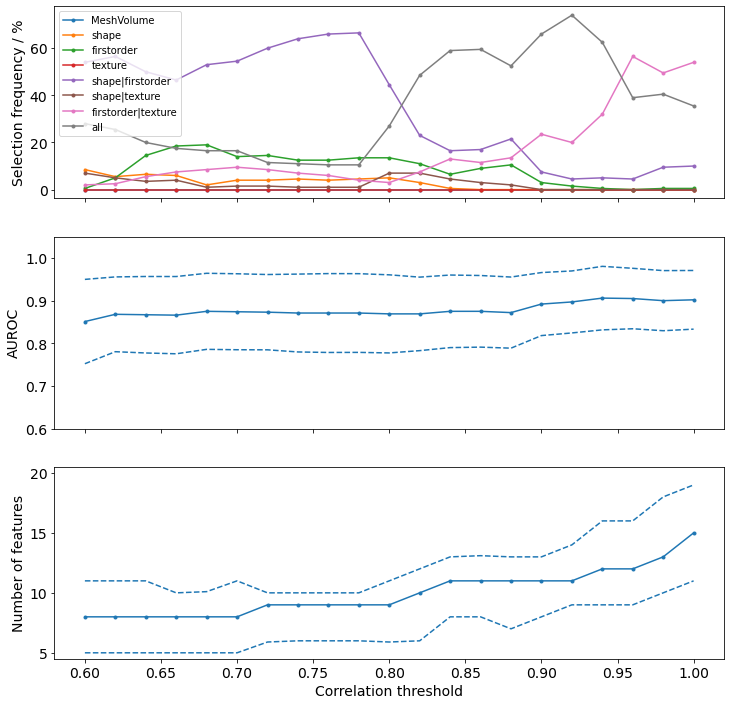

In [11]:
plt.rcParams['font.size'] = '14'
f,a = plt.subplots(3,1, figsize=(12,12))
for group in groupStrsDisp(groupHierarchy):
    a[0].plot(groupFrequencyDf['threshold'], 100*groupFrequencyDf[group], label=group, marker='.')
a[0].legend(fontsize=10)
a[0].get_xaxis().set_ticklabels([])
a[0].set_ylabel('Selection frequency / %')

a[1].plot(thresholds, cv_mean, marker='.')
a[1].plot(thresholds, np.array(cv_mean) + np.array(cv_std), linestyle='--', color='C0')
a[1].plot(thresholds, np.array(cv_mean) - np.array(cv_std), linestyle='--', color='C0')
a[1].set_ylim([0.6, 1.05])
a[1].get_xaxis().set_ticklabels([])
a[1].set_ylabel('AUROC')

a[2].plot(thresholds, np.median(featureCount, axis=0), marker='.')
a[2].plot(thresholds, np.quantile(featureCount, 0.9, axis=0), linestyle='--', color='C0')
a[2].plot(thresholds, np.quantile(featureCount, 0.1, axis=0), linestyle='--', color='C0')
a[2].set_xlabel('Correlation threshold')
a[2].set_ylabel('Number of features')
a[2].set_ylim([4.5, 20.5])

plt.show()

In [12]:
# get the experiment with threshold = 0.8

thresholdStr = '0.8'
model = experiments[thresholdStr]['model']
cv_result = experiments[thresholdStr]['cv_result']

In [13]:
print('AUROC (CV) = ' + str(np.round(np.mean(cv_result['test_score']),5)))

AUROC (CV) = 0.8686


In [14]:
# from fit to all data get the best feature group combination
groupStrsDisp(model.best_estimator_.steps[1][1].groupFilter)

'shape|firstorder'

In [15]:
# from fit to all data get the non-zero LR coefficients
colMask0 = copy.deepcopy(model.best_estimator_.steps[0][1].mask_)
colMask1 = model.best_estimator_.steps[1][1].colMask_
colMask0[colMask0] = colMask1
bc = np.zeros((X.shape[1]))
bc[colMask0] = copy.deepcopy(model.best_estimator_._final_estimator.coef_).ravel()
bestCoef = pd.DataFrame({'Feature':list(np.array(X.columns)[bc != 0]), 'Coef':list(bc[bc != 0])})
bestCoef = bestCoef.sort_values(by='Coef', ascending=False, key=abs)
bestCoef = bestCoef.loc[bestCoef.Coef != 0,:]
bestCoef.style.hide_index()

Feature,Coef
firstorder_90Percentile,-1.591571
firstorder_InterquartileRange,0.992390
firstorder_Maximum,0.935322
shape_MeshVolume,0.580460
firstorder_Kurtosis,-0.414955
shape_Elongation,-0.319122
shape_Sphericity,-0.303267
firstorder_RootMeanSquared,-0.252986
shape_Flatness,0.210838


In [16]:
# get frequency that each feature is selected

bc = np.zeros((len(cv_result['estimator']), X.shape[1]))
for n, ecv in enumerate(cv_result['estimator']):
    colMask0 = copy.deepcopy(ecv.best_estimator_.steps[0][1].mask_)
    colMask1 = ecv.best_estimator_.steps[1][1].colMask_
    colMask0[colMask0] = colMask1
    bc[n, colMask0] = copy.deepcopy(ecv.best_estimator_._final_estimator.coef_)
    coef = pd.DataFrame({'Feature':list(np.array(X.columns)[bc[n,:].ravel() != 0]), 'Coef':list(bc[n,bc[n,:] != 0])})
    coef = coef.sort_values(by='Coef', ascending=False, key=abs)
    coef = coef.loc[coef.Coef != 0,:]

pdFreq = pd.DataFrame({'Feature':X.columns, 'Frequency':np.sum(bc !=0, axis=0)/(n_splits*n_repeats)*100})

# add coeff values for best fit
pdFreq['Coef'] = ''
for _, row in bestCoef.iterrows():
    rowIndex = pdFreq.index[pdFreq.Feature == row.Feature].tolist()[0]
    pdFreq.loc[rowIndex,'Coef'] = row.Coef

pdFreq = pdFreq.loc[pdFreq.Frequency>0,:].sort_values(by='Frequency', ascending=False, key=abs)

pd.set_option('display.precision', 2)
pdFreq.style.hide_index()

Feature,Frequency,Coef
firstorder_RootMeanSquared,87.50,-0.25
firstorder_Maximum,87.50,0.94
shape_MeshVolume,83.50,0.58
shape_Sphericity,83.50,-0.30
firstorder_90Percentile,83.50,-1.59
shape_Elongation,83.00,-0.32
firstorder_InterquartileRange,66.00,0.99
firstorder_Kurtosis,55.50,-0.41
ngtdm_Strength,33.00,
shape_Flatness,29.50,0.21


In [17]:
# from fit to all data get the non-zero LR coefficients
bc = np.zeros((len(thresholds), X.shape[1]))
row = 0
for threshStr, result in experiments.items():
    model = result['model']

    colMask0 = copy.deepcopy(model.best_estimator_.steps[0][1].mask_)
    colMask1 = model.best_estimator_.steps[1][1].colMask_
    colMask0[colMask0] = colMask1
    bc[row,colMask0] = copy.deepcopy(model.best_estimator_._final_estimator.coef_).ravel()
    row += 1
bestCoefs = pd.DataFrame(columns=X.columns, data=bc)
bestCoefs.insert(0, 'threshold', thresholds)

# trim off the last three rows as these are where the chosen group differs from VolumeFraction|shape
bestCoefs = bestCoefs.loc[0:17,:]

bestCoefs = bestCoefs.loc[:, (bestCoefs != 0).any(axis=0)]
bestCoefs.style.hide_index()

threshold,shape_Elongation,shape_Flatness,shape_MeshVolume,shape_Sphericity,shape_SurfaceVolumeRatio,firstorder_90Percentile,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_Median,firstorder_RootMeanSquared,firstorder_Skewness,glcm_Idmn,glcm_InverseVariance,glrlm_RunEntropy,glszm_LargeAreaLowGrayLevelEmphasis,glszm_SmallAreaEmphasis,glszm_ZoneEntropy,glszm_ZoneVariance,gldm_DependenceNonUniformityNormalized,ngtdm_Busyness,ngtdm_Strength
0.60,-0.21,0.00,1.01,-0.58,0.00,-1.50,0.00,-1.09,1.28,0.00,-0.22,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.62,-0.23,0.00,0.47,-0.37,0.00,-1.82,1.49,-0.58,1.20,0.00,-0.27,0.35,0.00,0.00,0.00,0.00,0.36,0.00,0.00,-0.34,0.00,-0.31
0.64,-0.16,0.00,0.53,-0.27,0.00,-1.55,0.95,-0.43,0.96,0.00,-0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.66,-0.16,0.00,0.53,-0.27,0.00,-1.55,0.95,-0.43,0.96,0.00,-0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.68,-0.16,0.00,0.53,-0.27,0.00,-1.55,0.95,-0.43,0.96,0.00,-0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.70,-0.16,0.00,0.53,-0.27,0.00,-1.55,0.95,-0.43,0.96,0.00,-0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.72,-0.32,0.21,0.58,-0.30,0.00,-1.59,0.99,-0.41,0.94,0.00,-0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.74,-0.32,0.21,0.58,-0.30,0.00,-1.59,0.99,-0.41,0.94,0.00,-0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.76,-0.32,0.21,0.58,-0.30,0.00,-1.59,0.99,-0.41,0.94,0.00,-0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.78,-0.32,0.21,0.58,-0.30,0.00,-1.59,0.99,-0.41,0.94,0.00,-0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [18]:
# calculate net benefit for DCA
def calculate_net_benefit_score(y_true, y_pred, pt=0):
    _, fp, _, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    net_benefit = (tp - fp * (pt / (1 - pt))) / len(y_true)
    return net_benefit

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        # y_pred_label = y_pred_score
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp - fp * (thresh / (1 - thresh))) / n
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp - tn * (thresh / (1 - thresh))) / total
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

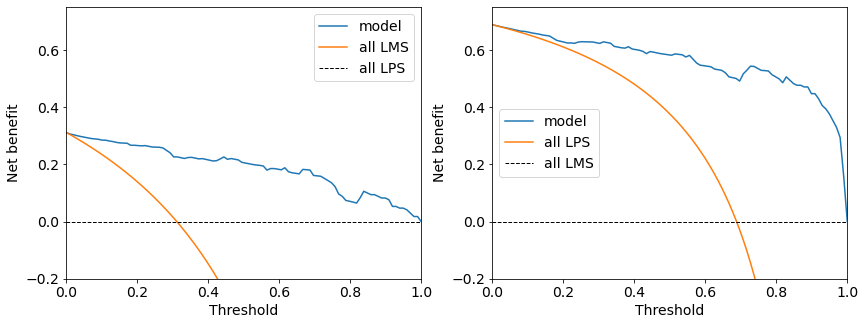

In [19]:
thresholdsDCA = np.linspace(1e-6,1-1e-6,100)

y_pred_score_LMS = model.predict_proba(X)[:,0]
net_benefit_model_LMS = calculate_net_benefit_model(thresholdsDCA, y_pred_score_LMS, np.array(y=='LMS').astype(int))
net_benefit_all_LMS = calculate_net_benefit_all(thresholdsDCA, np.array(y=='LMS').astype(int))

y_pred_score_LPS = model.predict_proba(X)[:,1]
net_benefit_model_LPS = calculate_net_benefit_model(thresholdsDCA, y_pred_score_LPS, np.array(y=='LPS').astype(int))
net_benefit_all_LPS = calculate_net_benefit_all(thresholdsDCA, np.array(y=='LPS').astype(int))

f,a = plt.subplots(1,2, figsize=(14,5))

a[0].plot(thresholdsDCA, net_benefit_model_LMS, label='model')
a[0].plot(thresholdsDCA, net_benefit_all_LMS, label='all LMS')
a[0].plot(thresholdsDCA, np.zeros(len(thresholdsDCA)), linewidth=1, linestyle='--', color='k', label='all LPS')
a[0].legend()
a[0].set_xlim([0, 1])
a[0].set_ylim([-0.2, 0.75])
a[0].set_xlabel('Threshold')
a[0].set_ylabel('Net benefit')

a[1].plot(thresholdsDCA, net_benefit_model_LPS, label='model')
a[1].plot(thresholdsDCA, net_benefit_all_LPS, label='all LPS')
a[1].plot(thresholdsDCA, np.zeros(len(thresholdsDCA)), linewidth=1, linestyle='--', color='k', label='all LMS')
a[1].legend()
a[1].set_xlim([0, 1])
a[1].set_ylim([-0.2, 0.75])
a[1].set_xlabel('Threshold')
a[1].set_ylabel('Net benefit')

plt.show()